In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [4]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, TimeDistributed
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [5]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-5-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [6]:
df.loc[df['activity'].isin(['Walking', 'Jogging', 'Upstairs', 'Downstairs']), 'static_dynamic'] = 0
df.loc[df['activity'].isin(['Sitting', 'Standing']), 'static_dynamic'] = 1
df


,user_id,activity,timestamp,x_axis,y_axis,z_axis,static_dynamic
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,0.0
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,0.0
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,0.0
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,0.0
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,0.0
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,1.0
1098201,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,1.0
1098202,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,1.0
1098203,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,1.0


In [7]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,static_dynamic,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,0.0,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,0.0,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,0.0,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,0.0,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,0.0,1
...,...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,1.0,4
1098201,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,1.0,4
1098202,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,1.0,4
1098203,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,1.0,4


<Axes: xlabel='static_dynamic', ylabel='count'>

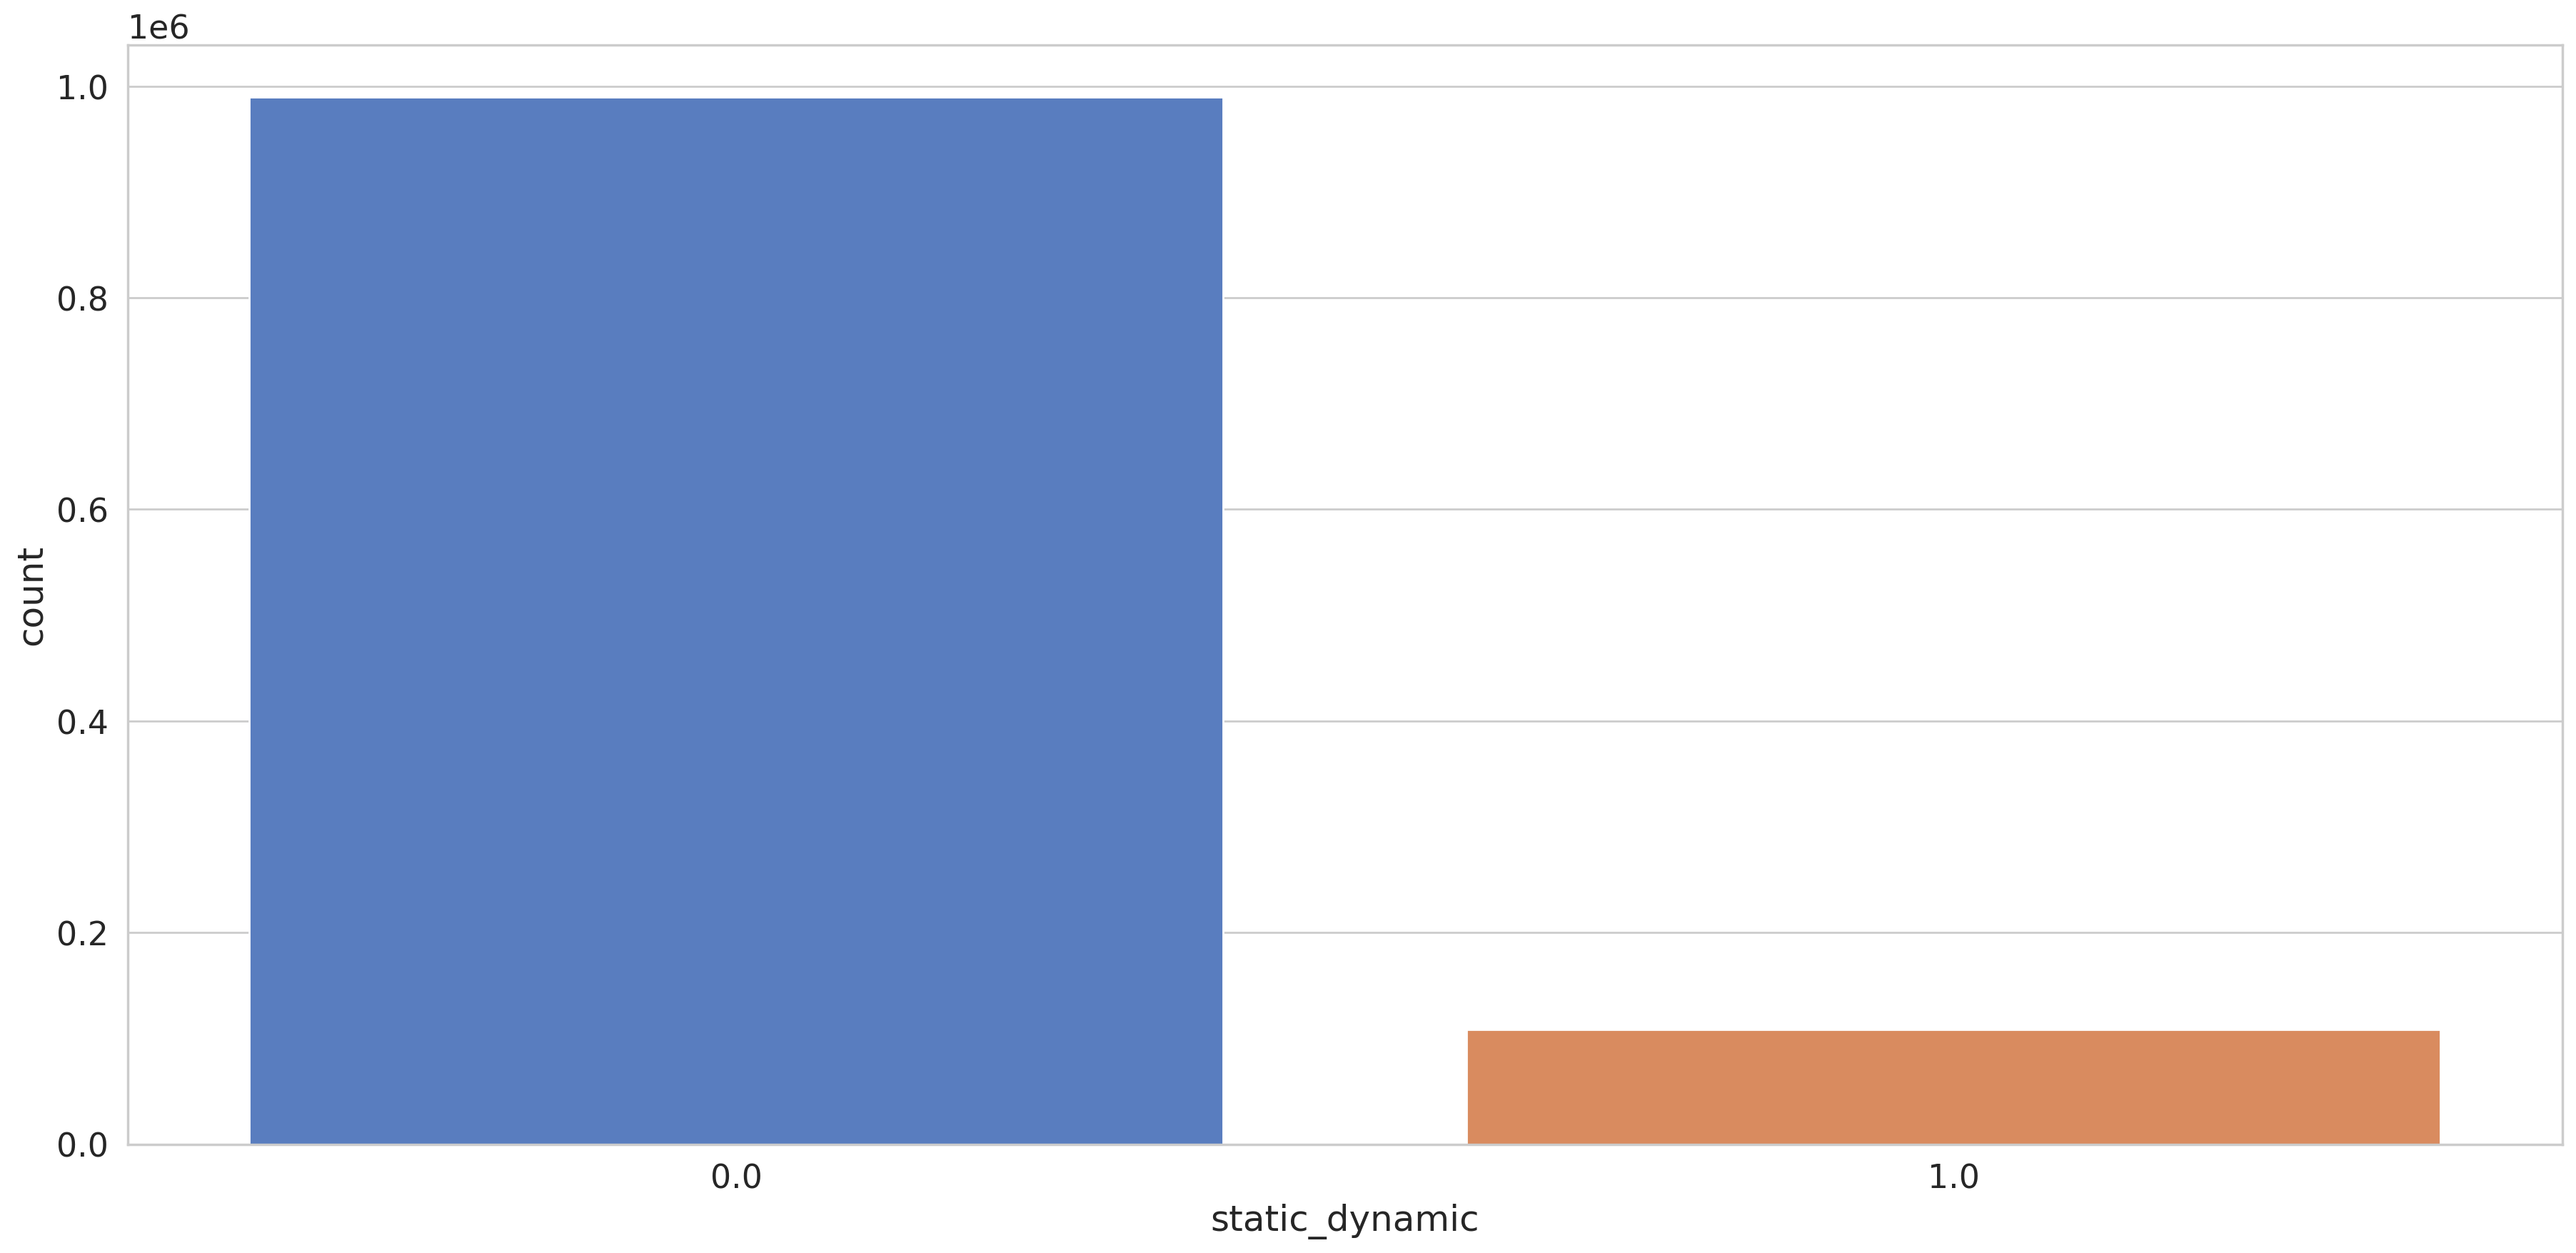

In [8]:
sns.countplot(x = "static_dynamic", data = df, order = df.static_dynamic.value_counts().index)

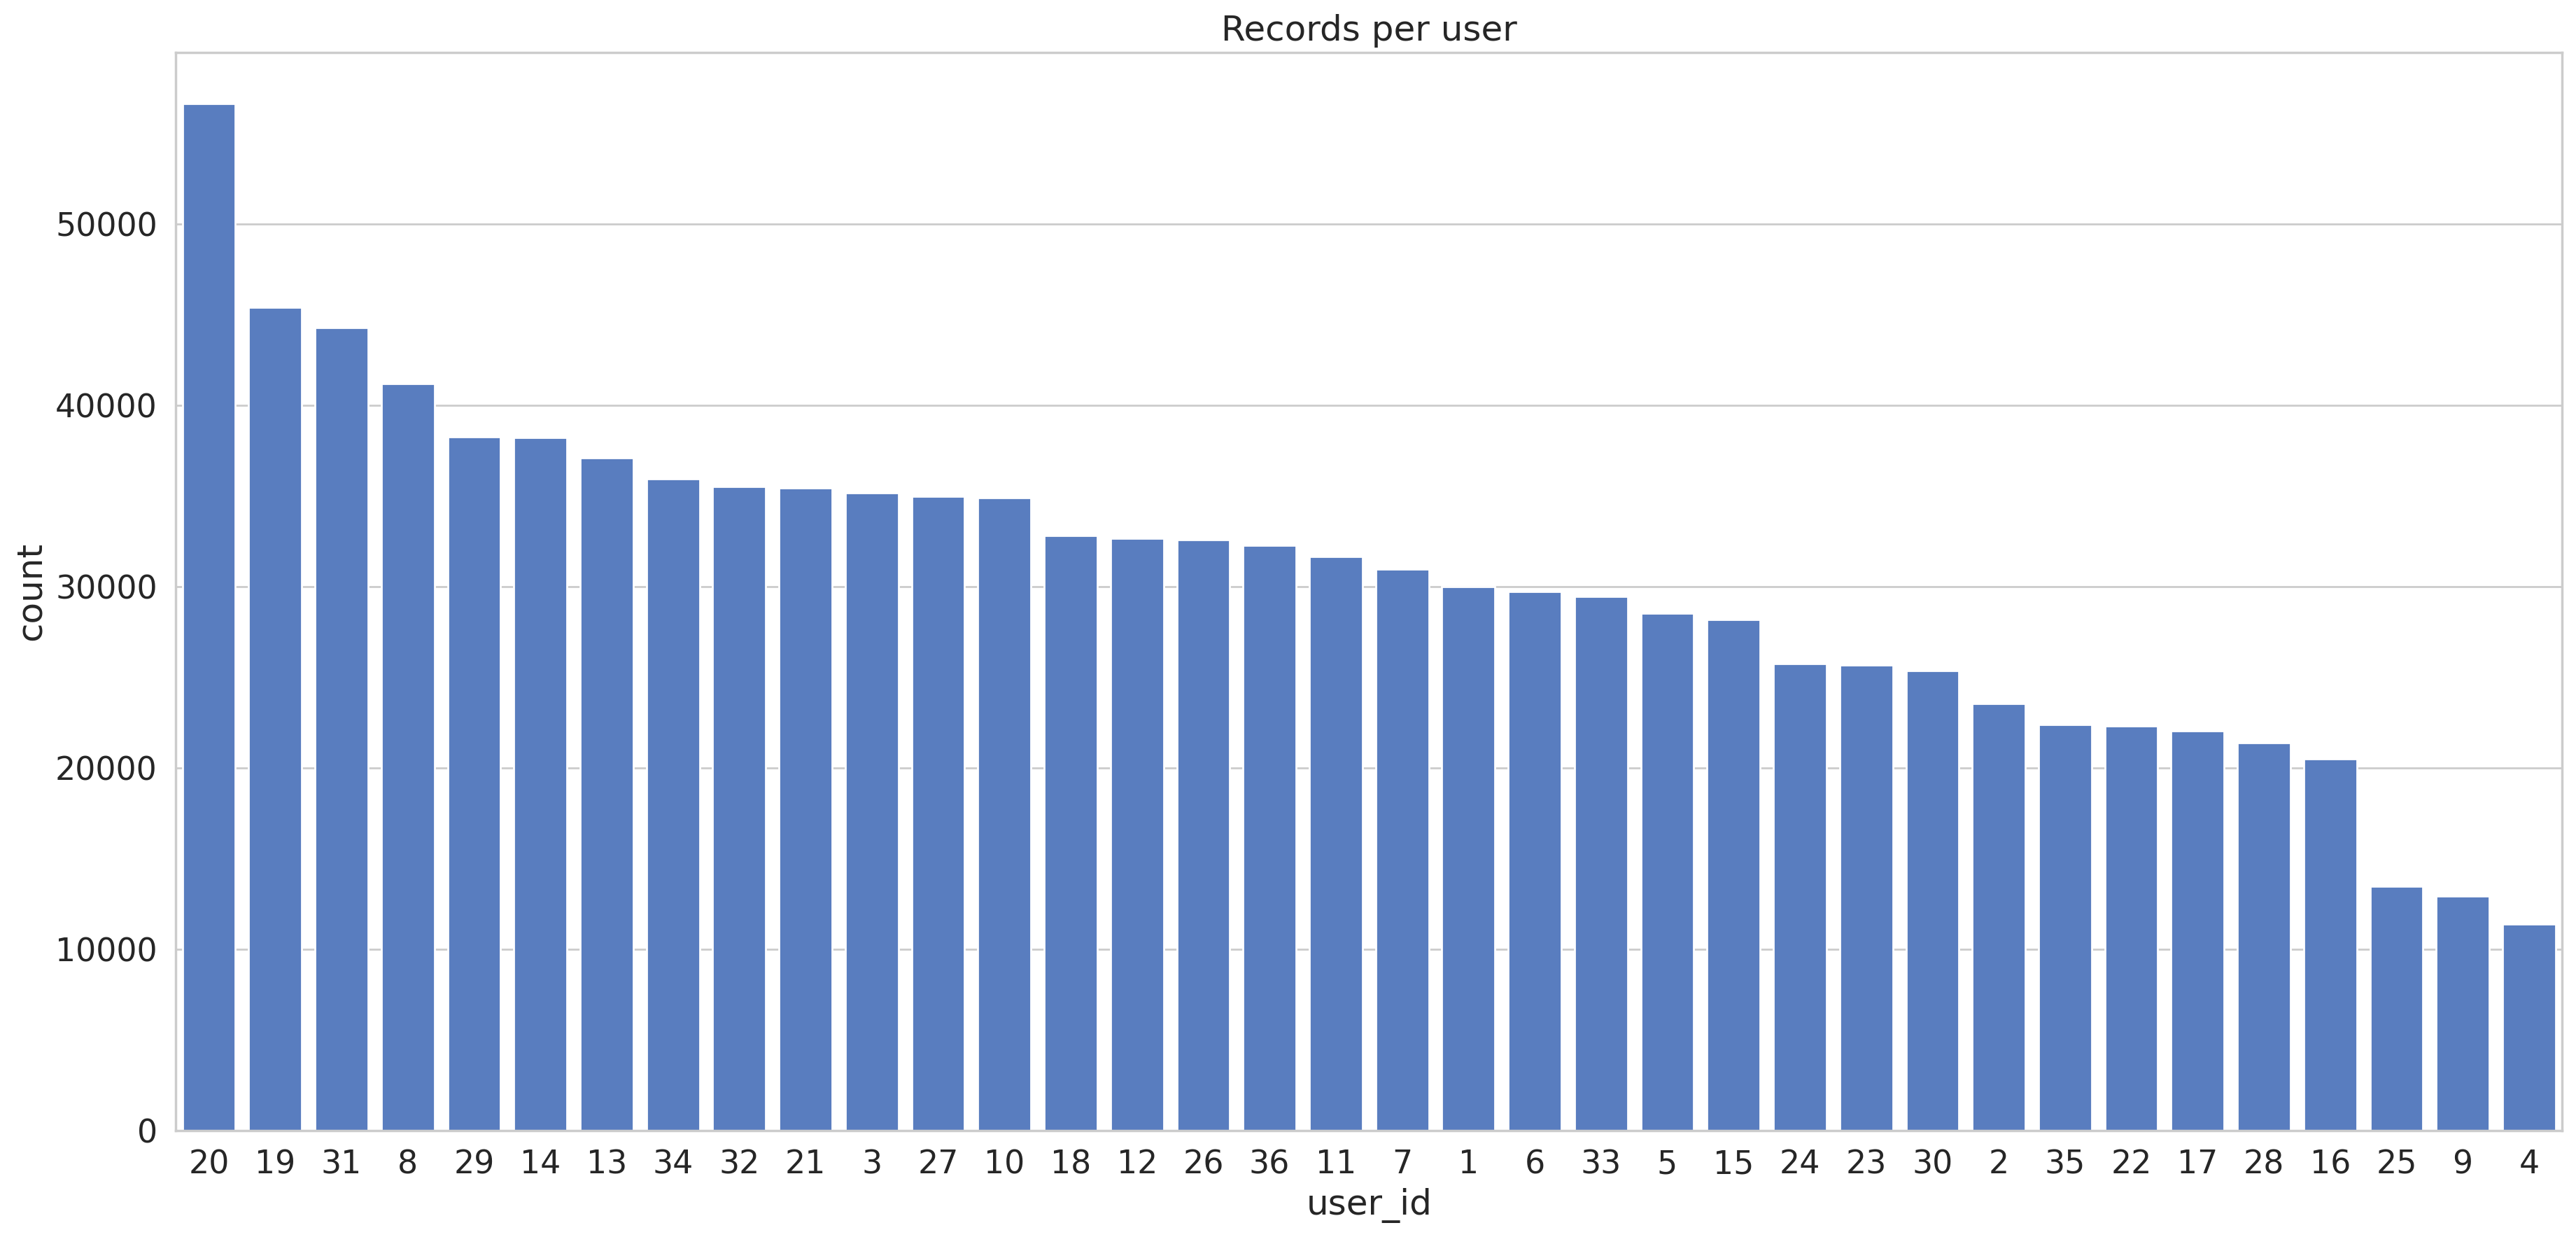

In [9]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


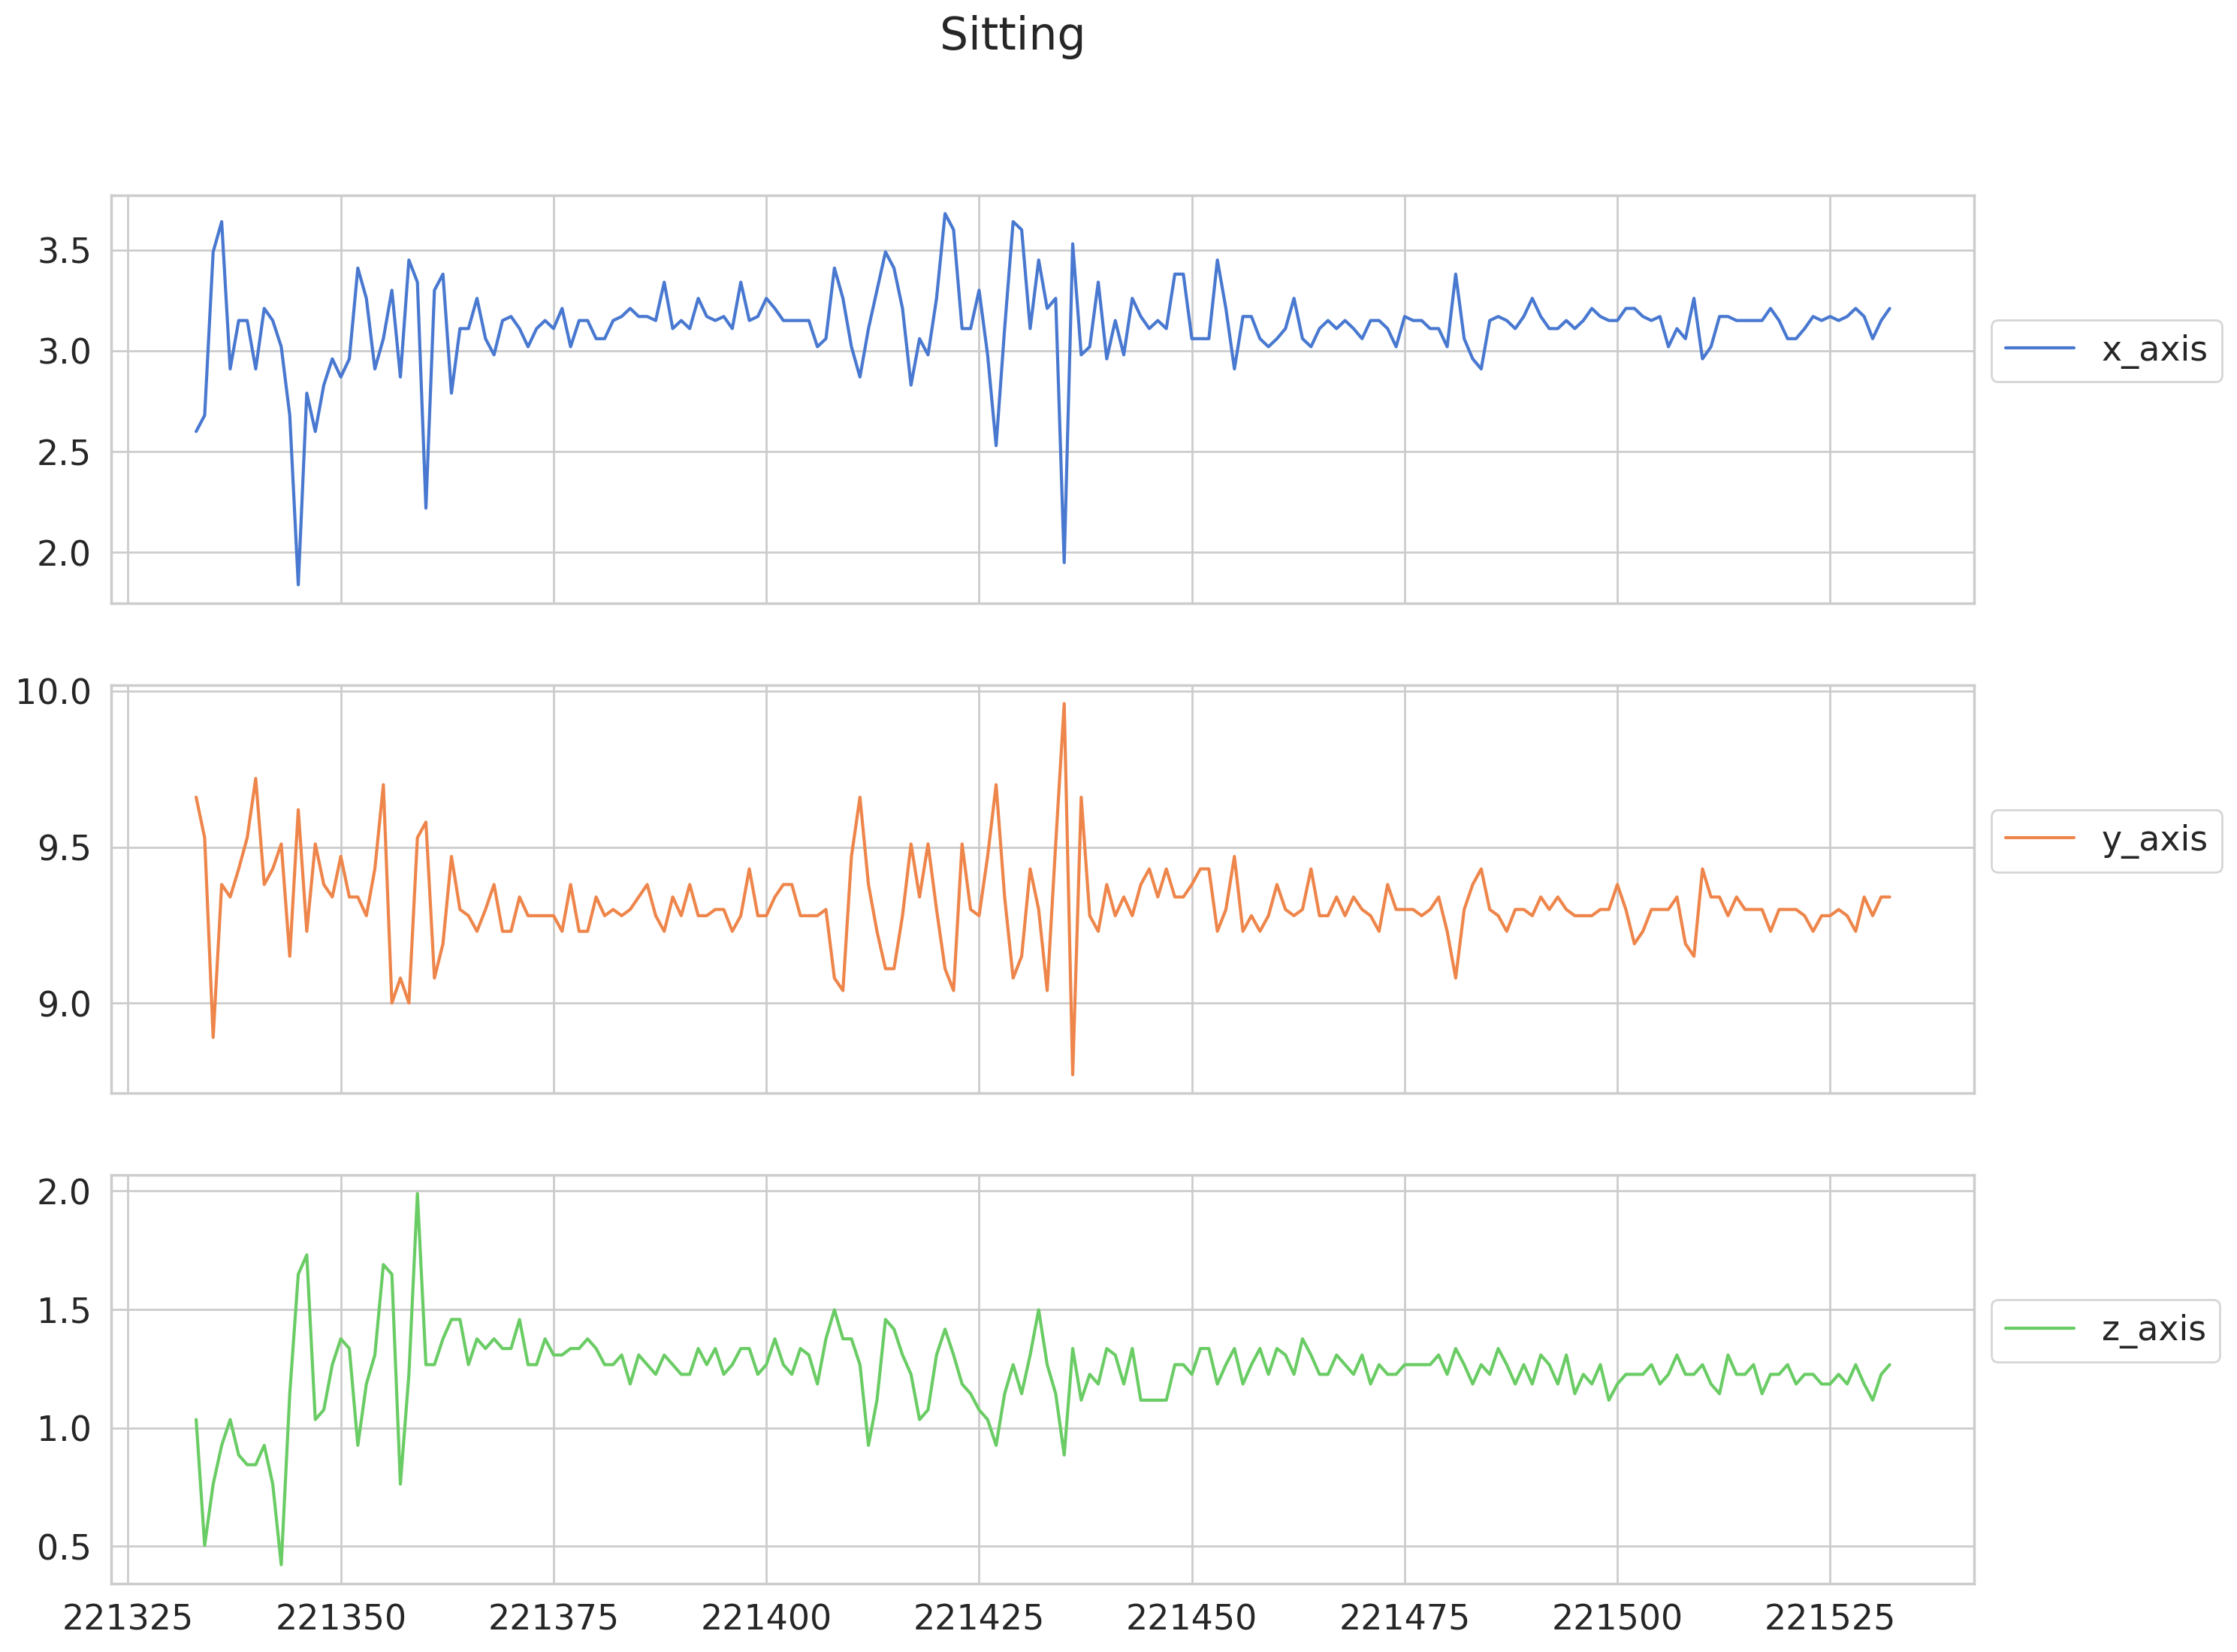

In [10]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [11]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,user_id,activity,timestamp,x_axis,y_axis,z_axis,static_dynamic,ActivityEncoded
0,33,Jogging,49105962326000,-0.131961,0.566215,0.102015,0.0,1
1,33,Jogging,49106062271000,0.648740,0.397381,0.193001,0.0,1
2,33,Jogging,49106112167000,0.633834,0.351926,-0.016543,0.0,1
3,33,Jogging,49106222305000,-0.120782,1.259408,0.612089,0.0,1
4,33,Jogging,49106332290000,-0.199038,0.498032,1.458535,0.0,1
...,...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,1.194254,-1.132300,0.342105,1.0,4
1098201,19,Sitting,131623371431000,1.199726,-1.119190,0.350202,1.0,4
1098202,19,Sitting,131623411592000,1.205198,-1.109654,0.342105,1.0,4
1098203,19,Sitting,131623491487000,1.194254,-1.119190,0.350202,1.0,4


In [12]:
X_data = df[['x_axis', 'y_axis','z_axis']]
y_data = df['static_dynamic']

In [13]:
X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(702850, 3) (702850,)
(219641, 3) (219641,)


In [14]:
print ("==================================")
print (" ACCURACY OF OTHER ML CLASSIFIERS" )
print ("==================================")


 ACCURACY OF OTHER ML CLASSIFIERS


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# SVC


--- SVM Classifier ---
f1_score =  0.9373096167124714
0.9445003437427438
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    197974
         1.0       0.89      0.50      0.64     21667

    accuracy                           0.94    219641
   macro avg       0.92      0.75      0.80    219641
weighted avg       0.94      0.94      0.94    219641



<Axes: >

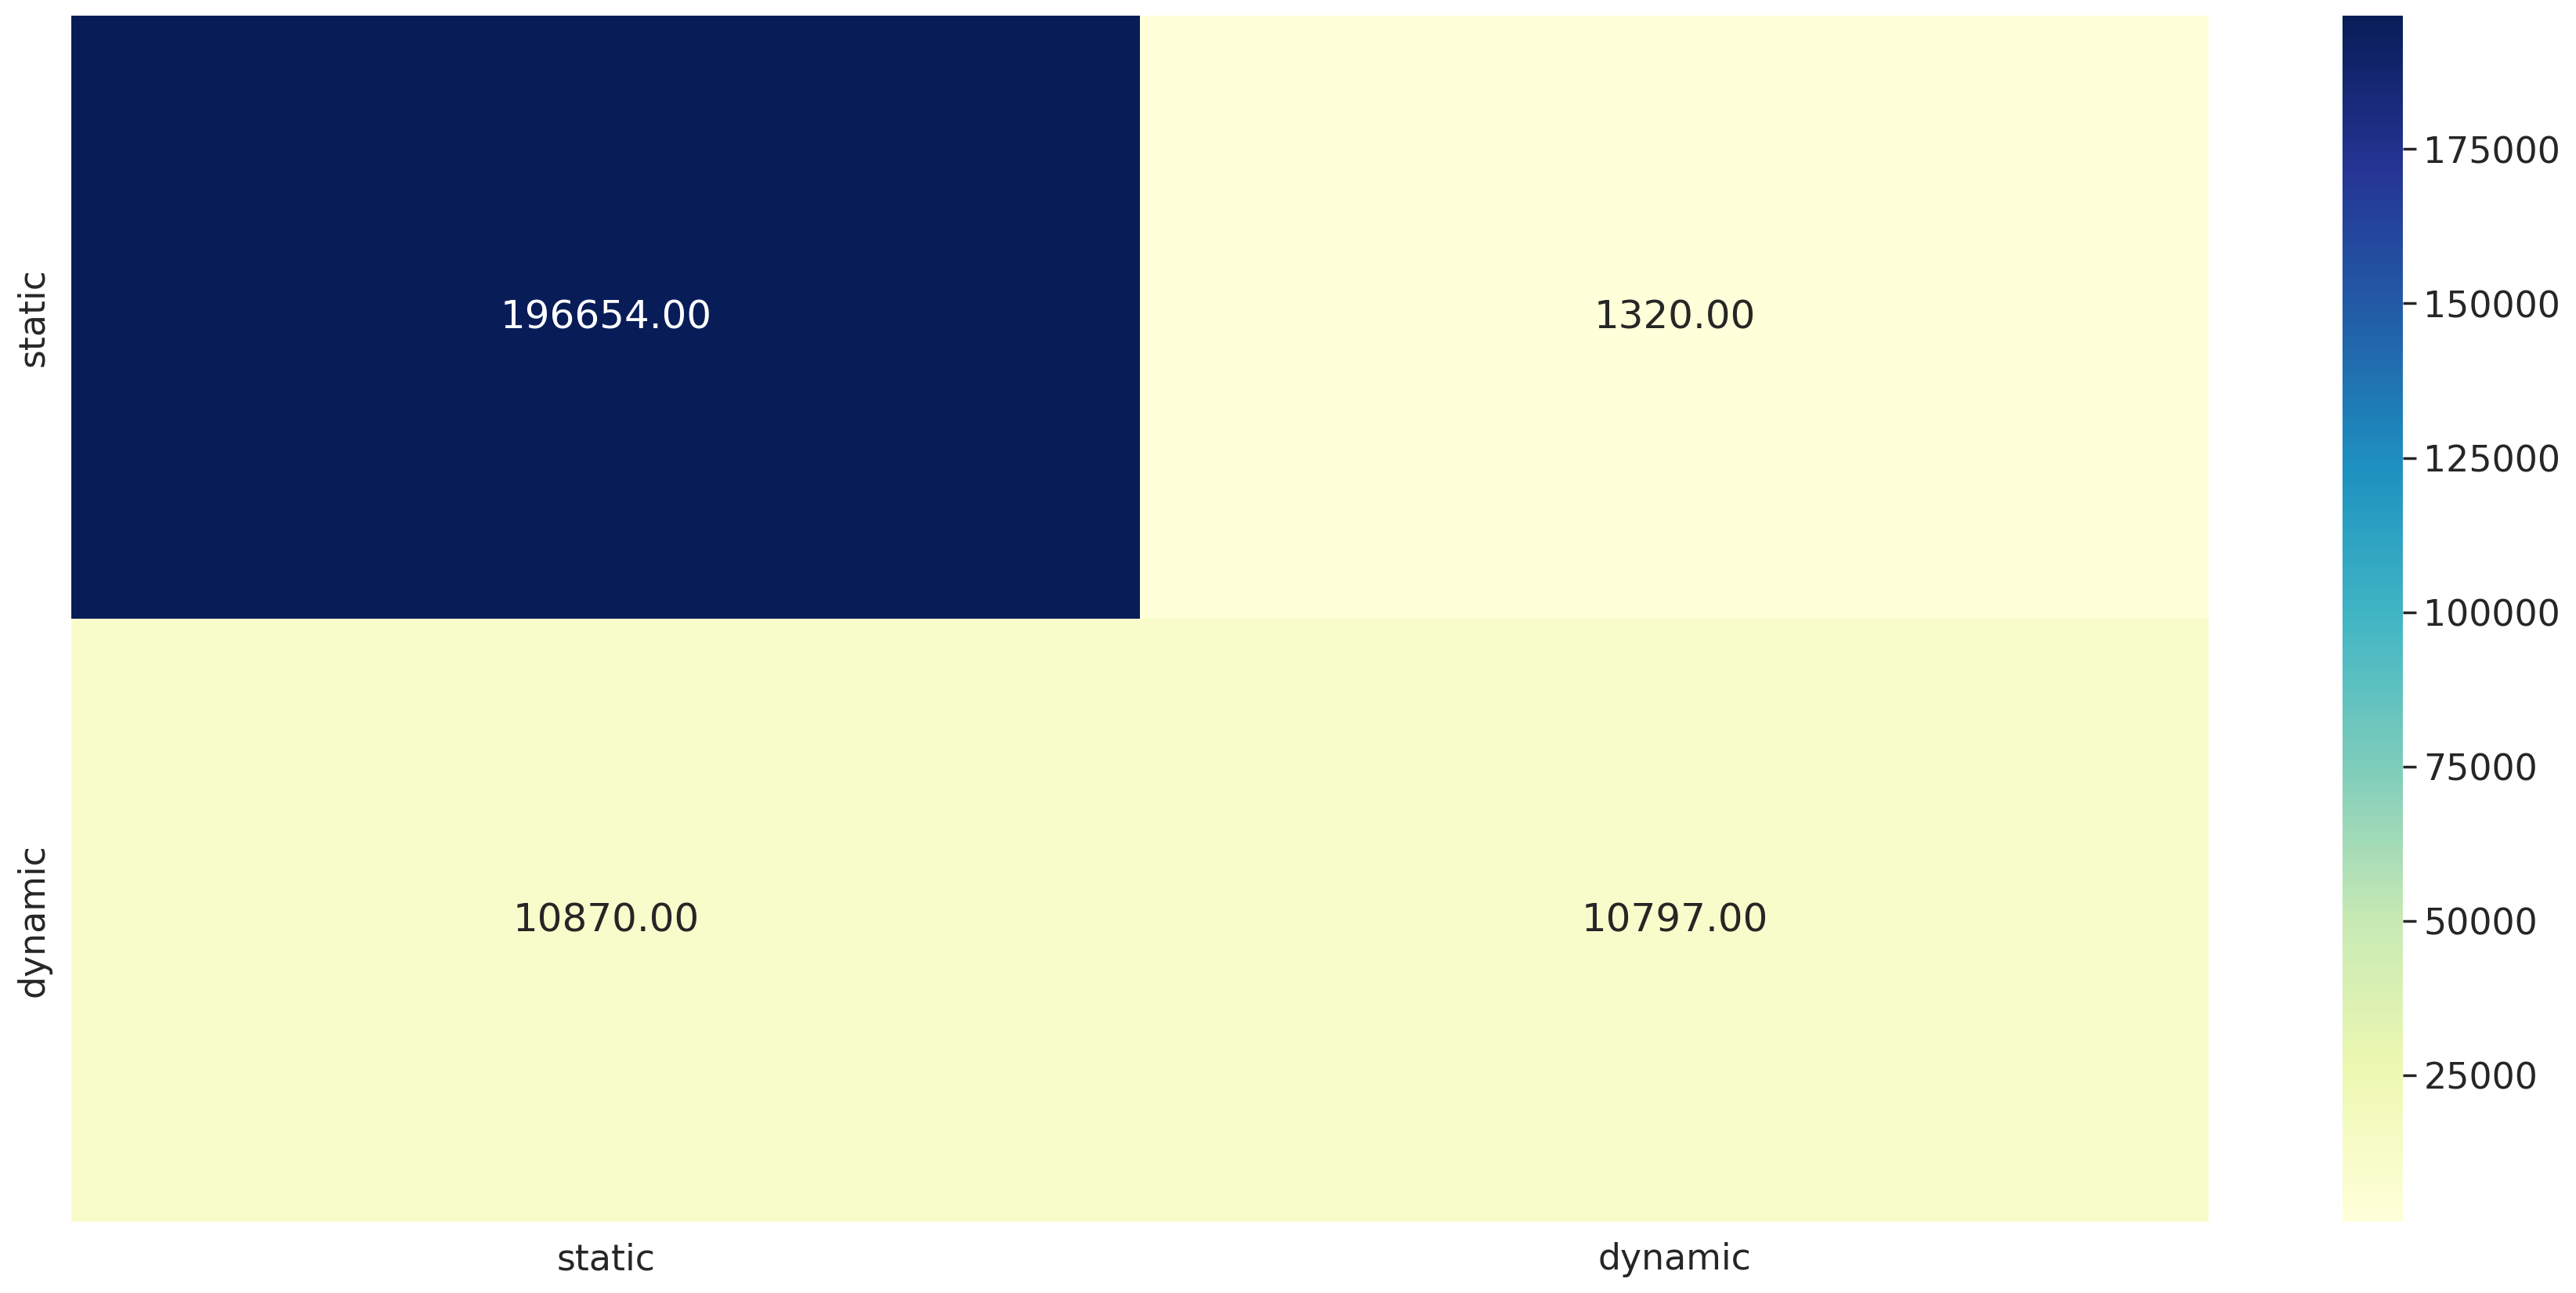

In [16]:
warnings.filterwarnings('ignore')

clf_svm = SVC(random_state=0)
clf_svm.fit(X_train, y_train)

pred_svm = clf_svm.predict(X_test)

print("\n--- SVM Classifier ---")

y_pred= pred_svm


LABELS = ['static', 'dynamic']
cm=confusion_matrix(y_test,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')


# Random Forest


--- Radom Forest ---

--- RF Classifier ---
f1_score =  0.9853024125857093
0.9854034538178209
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    197974
         1.0       0.94      0.91      0.92     21667

    accuracy                           0.99    219641
   macro avg       0.96      0.95      0.96    219641
weighted avg       0.99      0.99      0.99    219641



<Axes: >

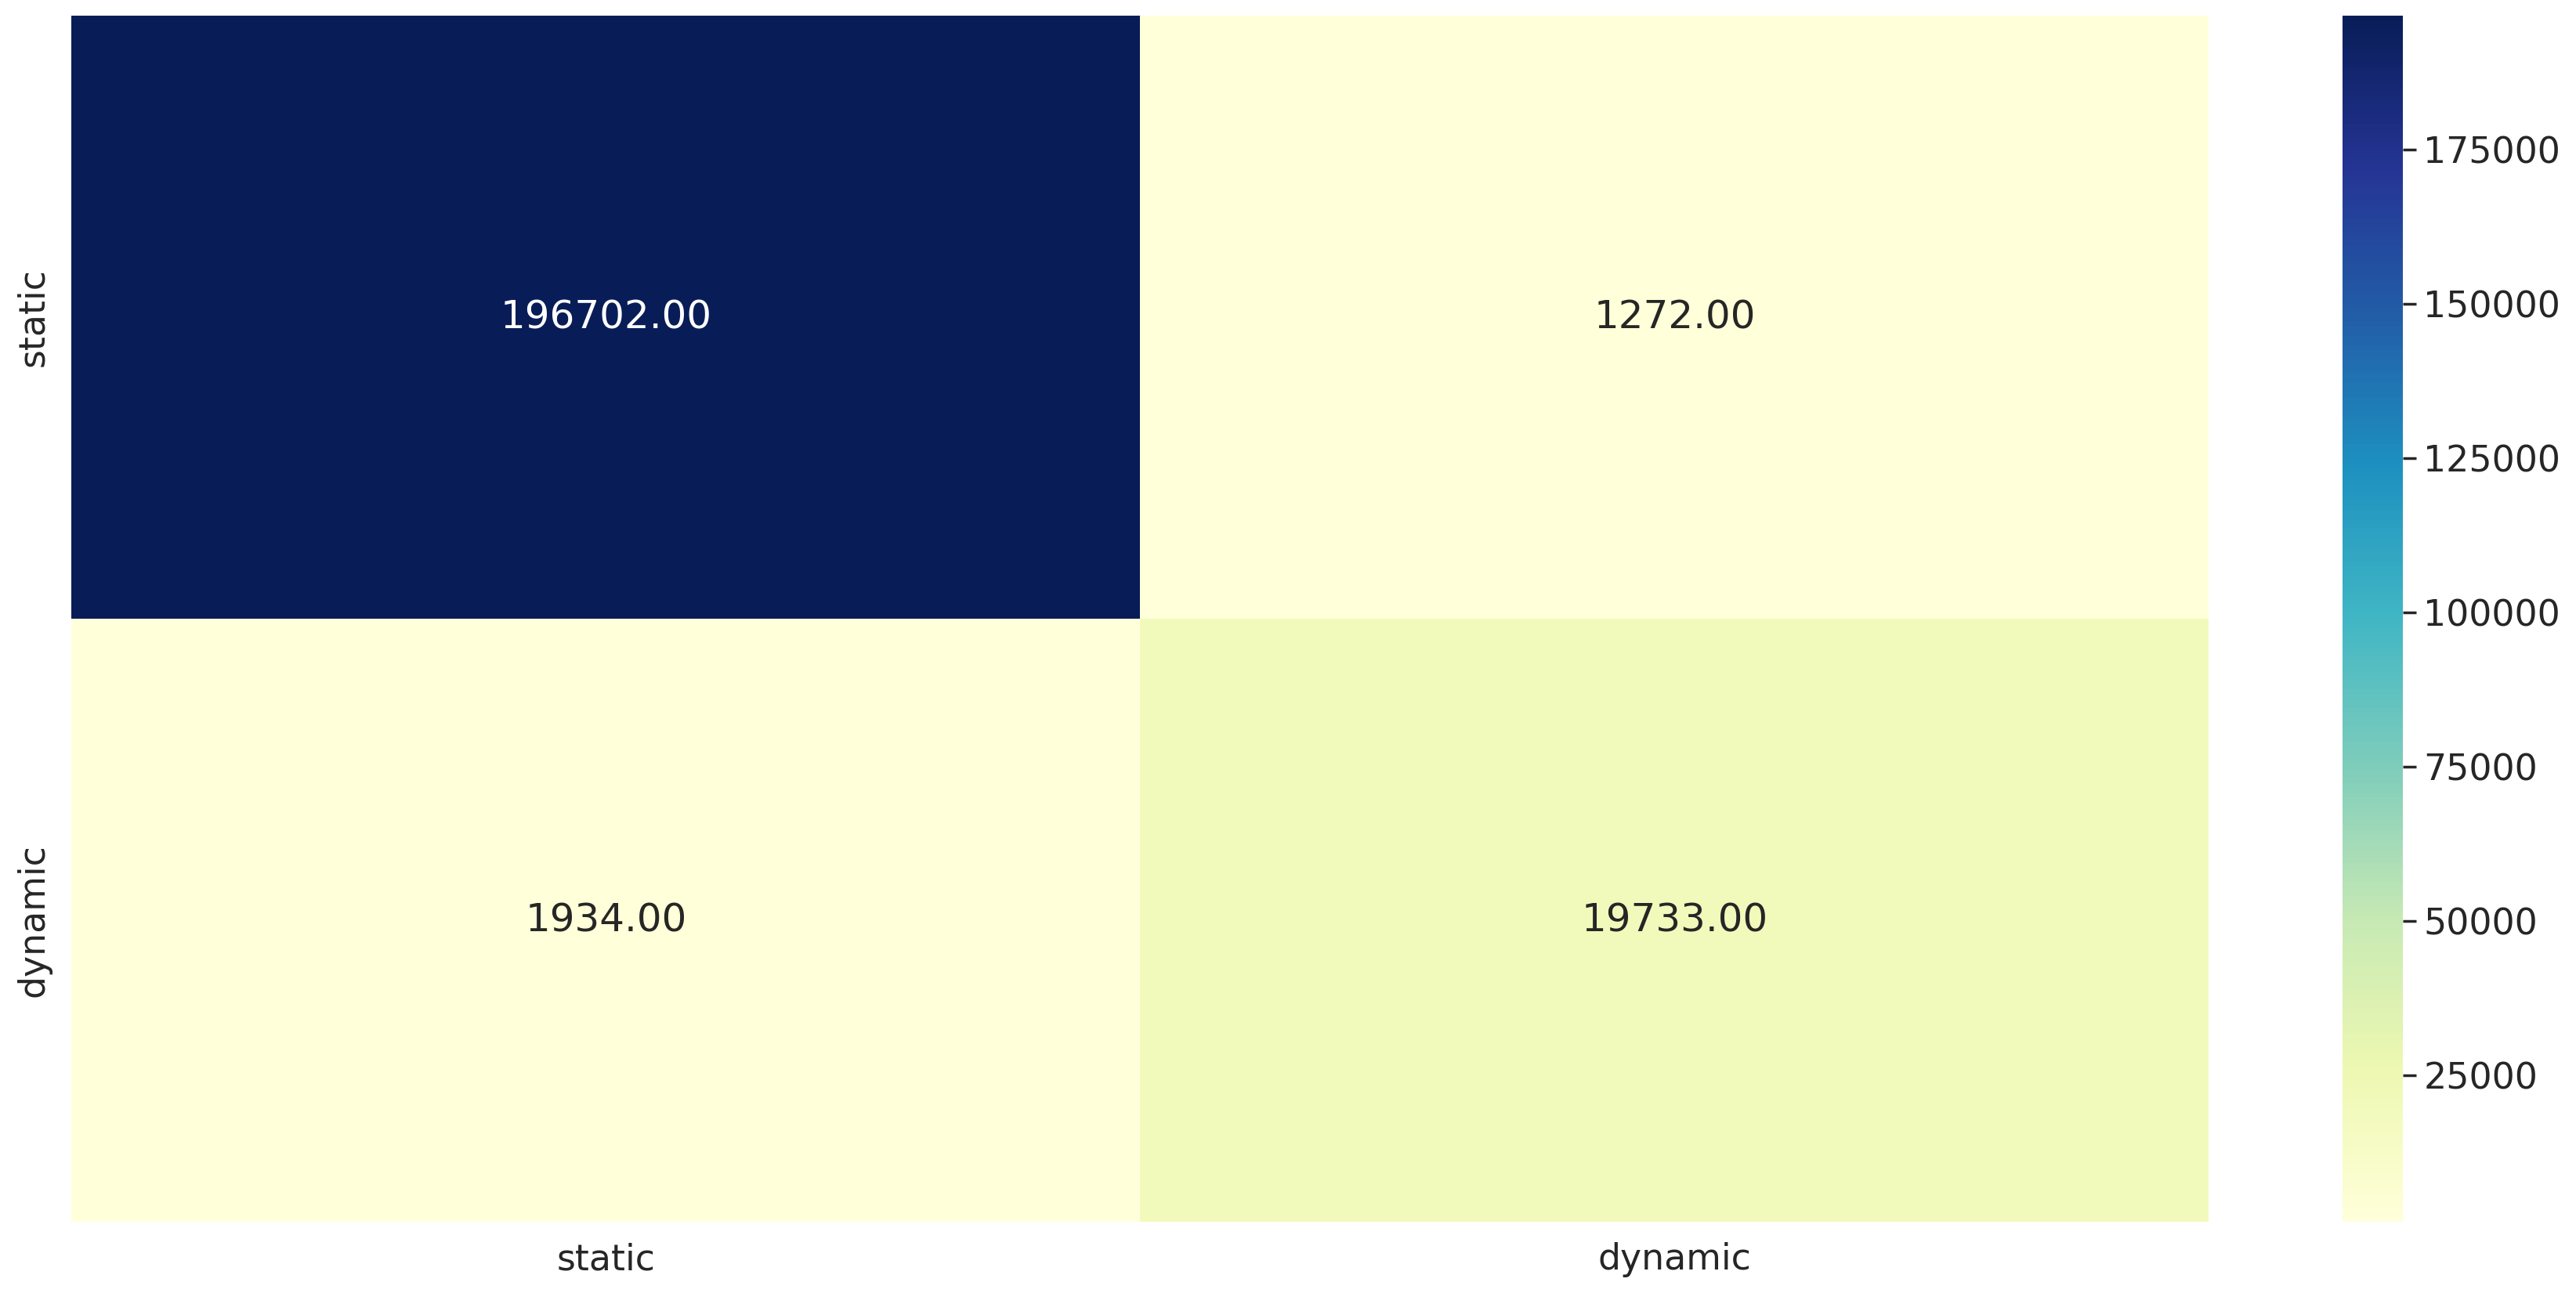

In [ ]:
warnings.filterwarnings('ignore')

print ("\n--- Radom Forest ---")
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

pred_clf = rf_clf.predict(X_test)

print("\n--- RF Classifier ---")

y_pred= pred_clf

LABELS = ['static', 'dynamic']
cm=confusion_matrix(y_test,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LogisticRegression


--- LR Classifier ---
f1_score =  0.8516731020388575
0.8955249702924317
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94    197974
         1.0       0.00      0.00      0.00     21667

    accuracy                           0.90    219641
   macro avg       0.45      0.50      0.47    219641
weighted avg       0.81      0.90      0.85    219641



<Axes: >

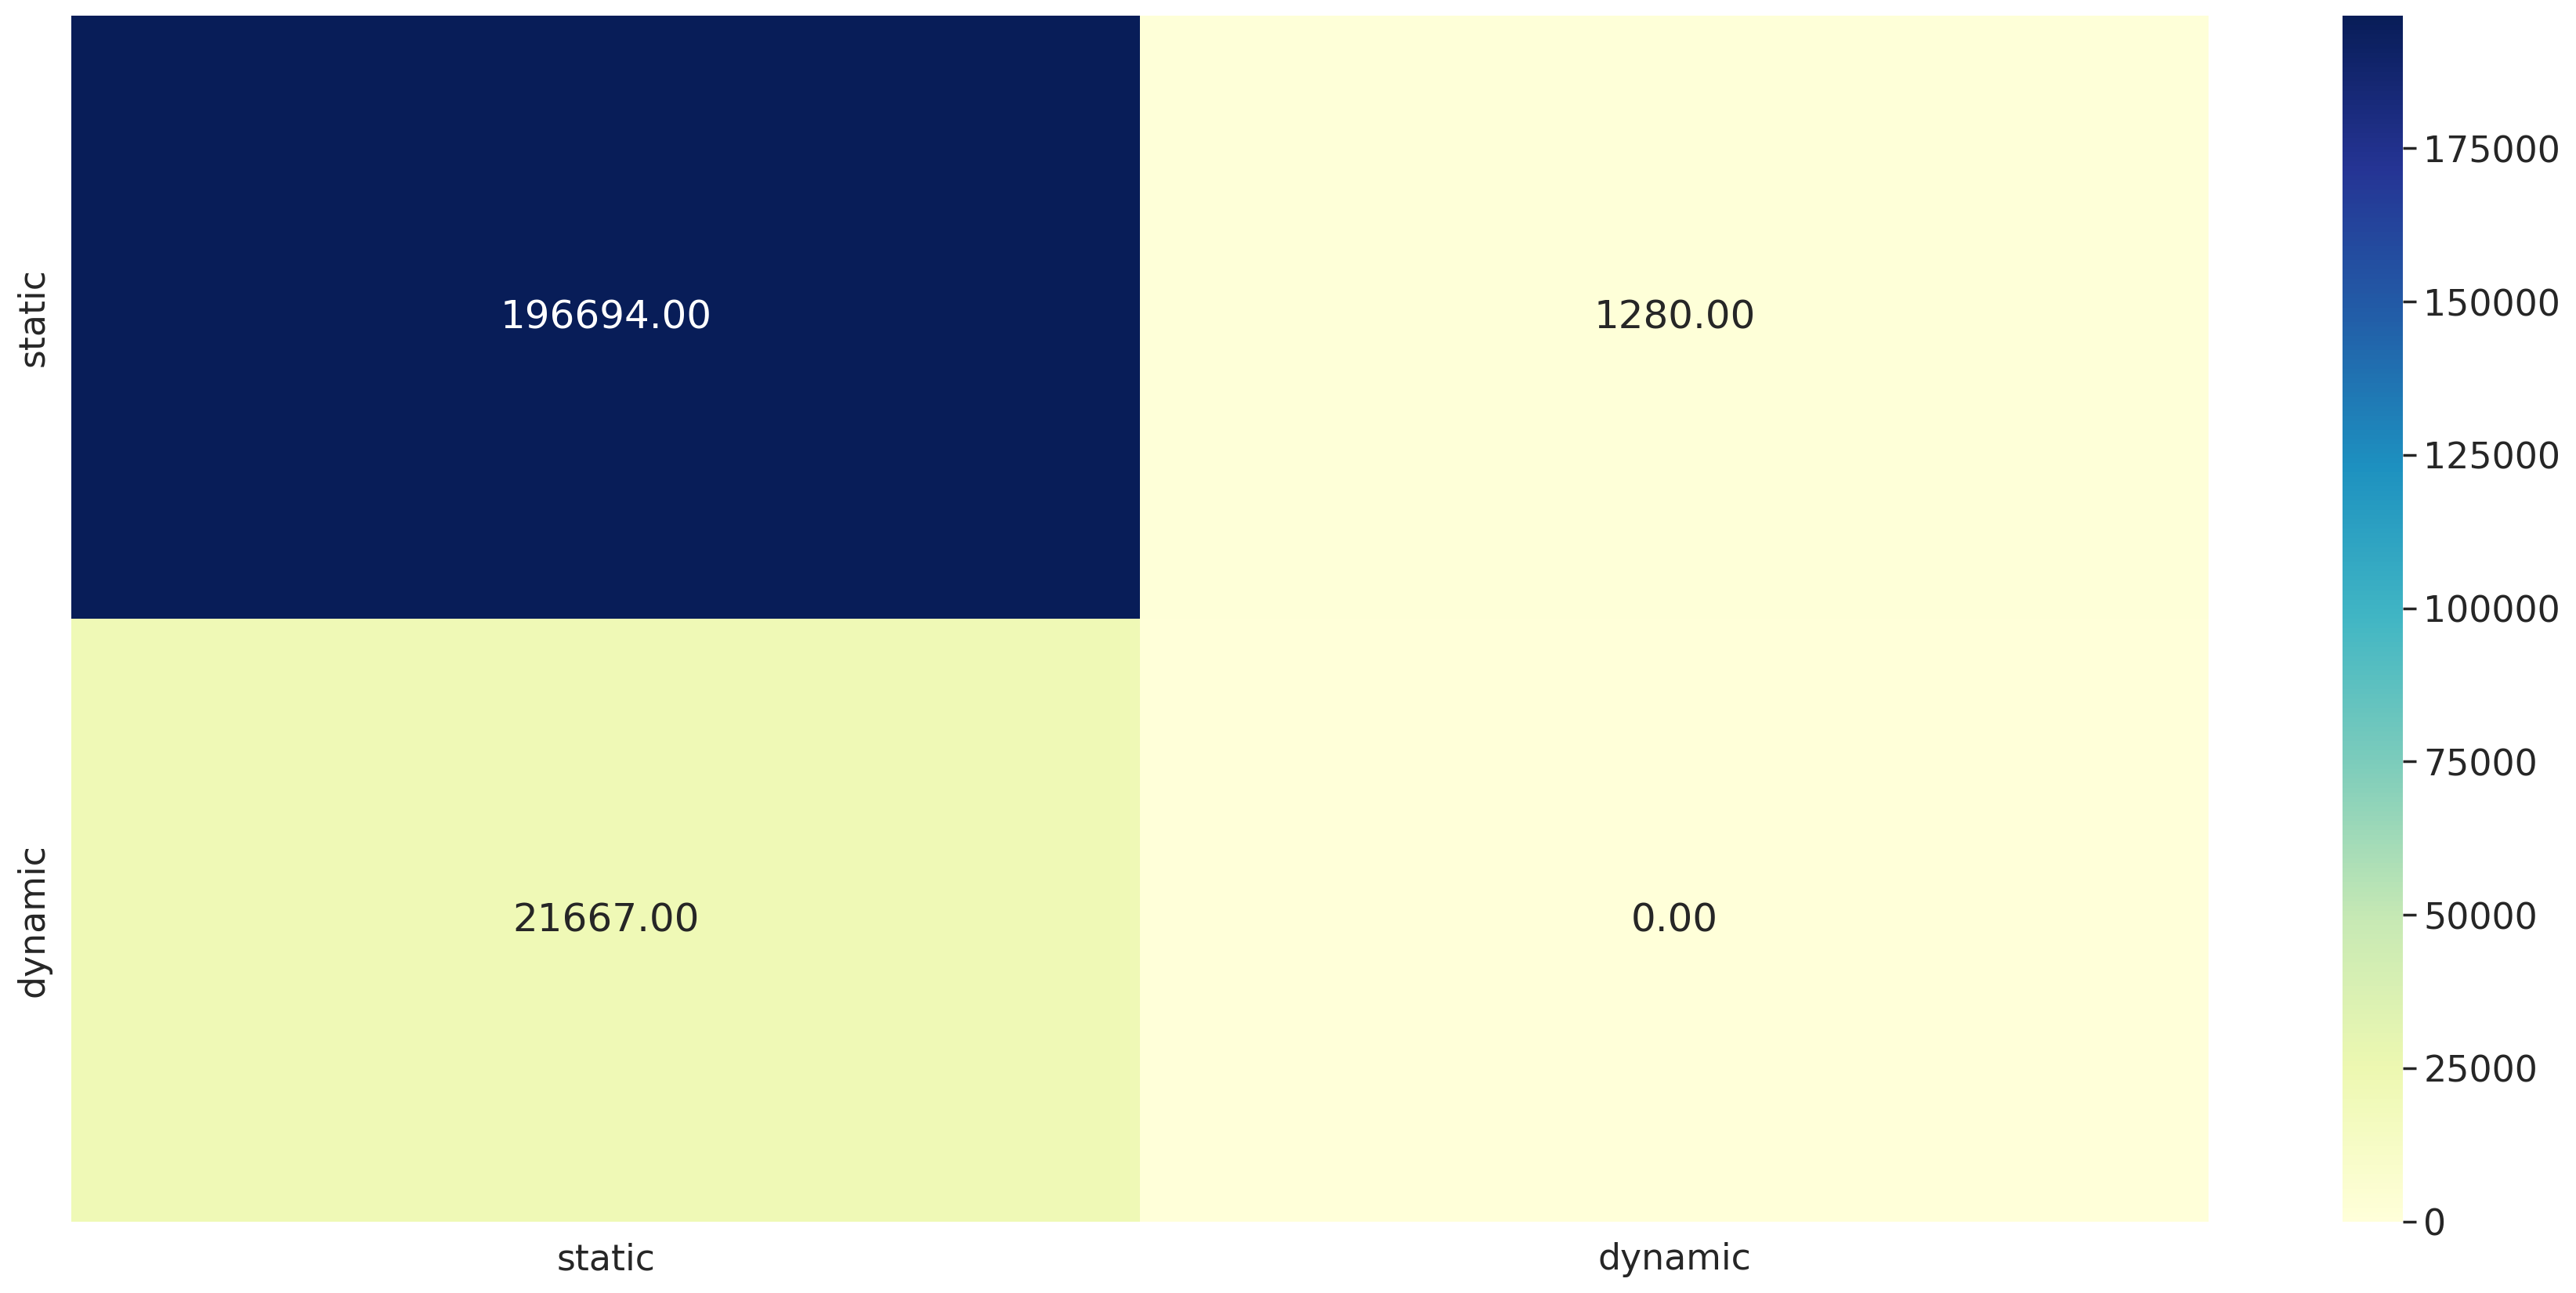

In [ ]:
# Build a logistic regression classifier and predict

clf_lr = LogisticRegression(random_state=0)
clf_lr.fit(X_train, y_train)

pred_lr = clf_lr.predict(X_test)

print("\n--- LR Classifier ---")

y_pred= pred_lr

LABELS = ['static', 'dynamic']

cm=confusion_matrix(y_test,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Decision TreeClassifier


--- DT Classifier ---
f1_score =  0.9793735767140063
0.9793208007612422
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    197974
         1.0       0.89      0.90      0.90     21667

    accuracy                           0.98    219641
   macro avg       0.94      0.94      0.94    219641
weighted avg       0.98      0.98      0.98    219641



<Axes: >

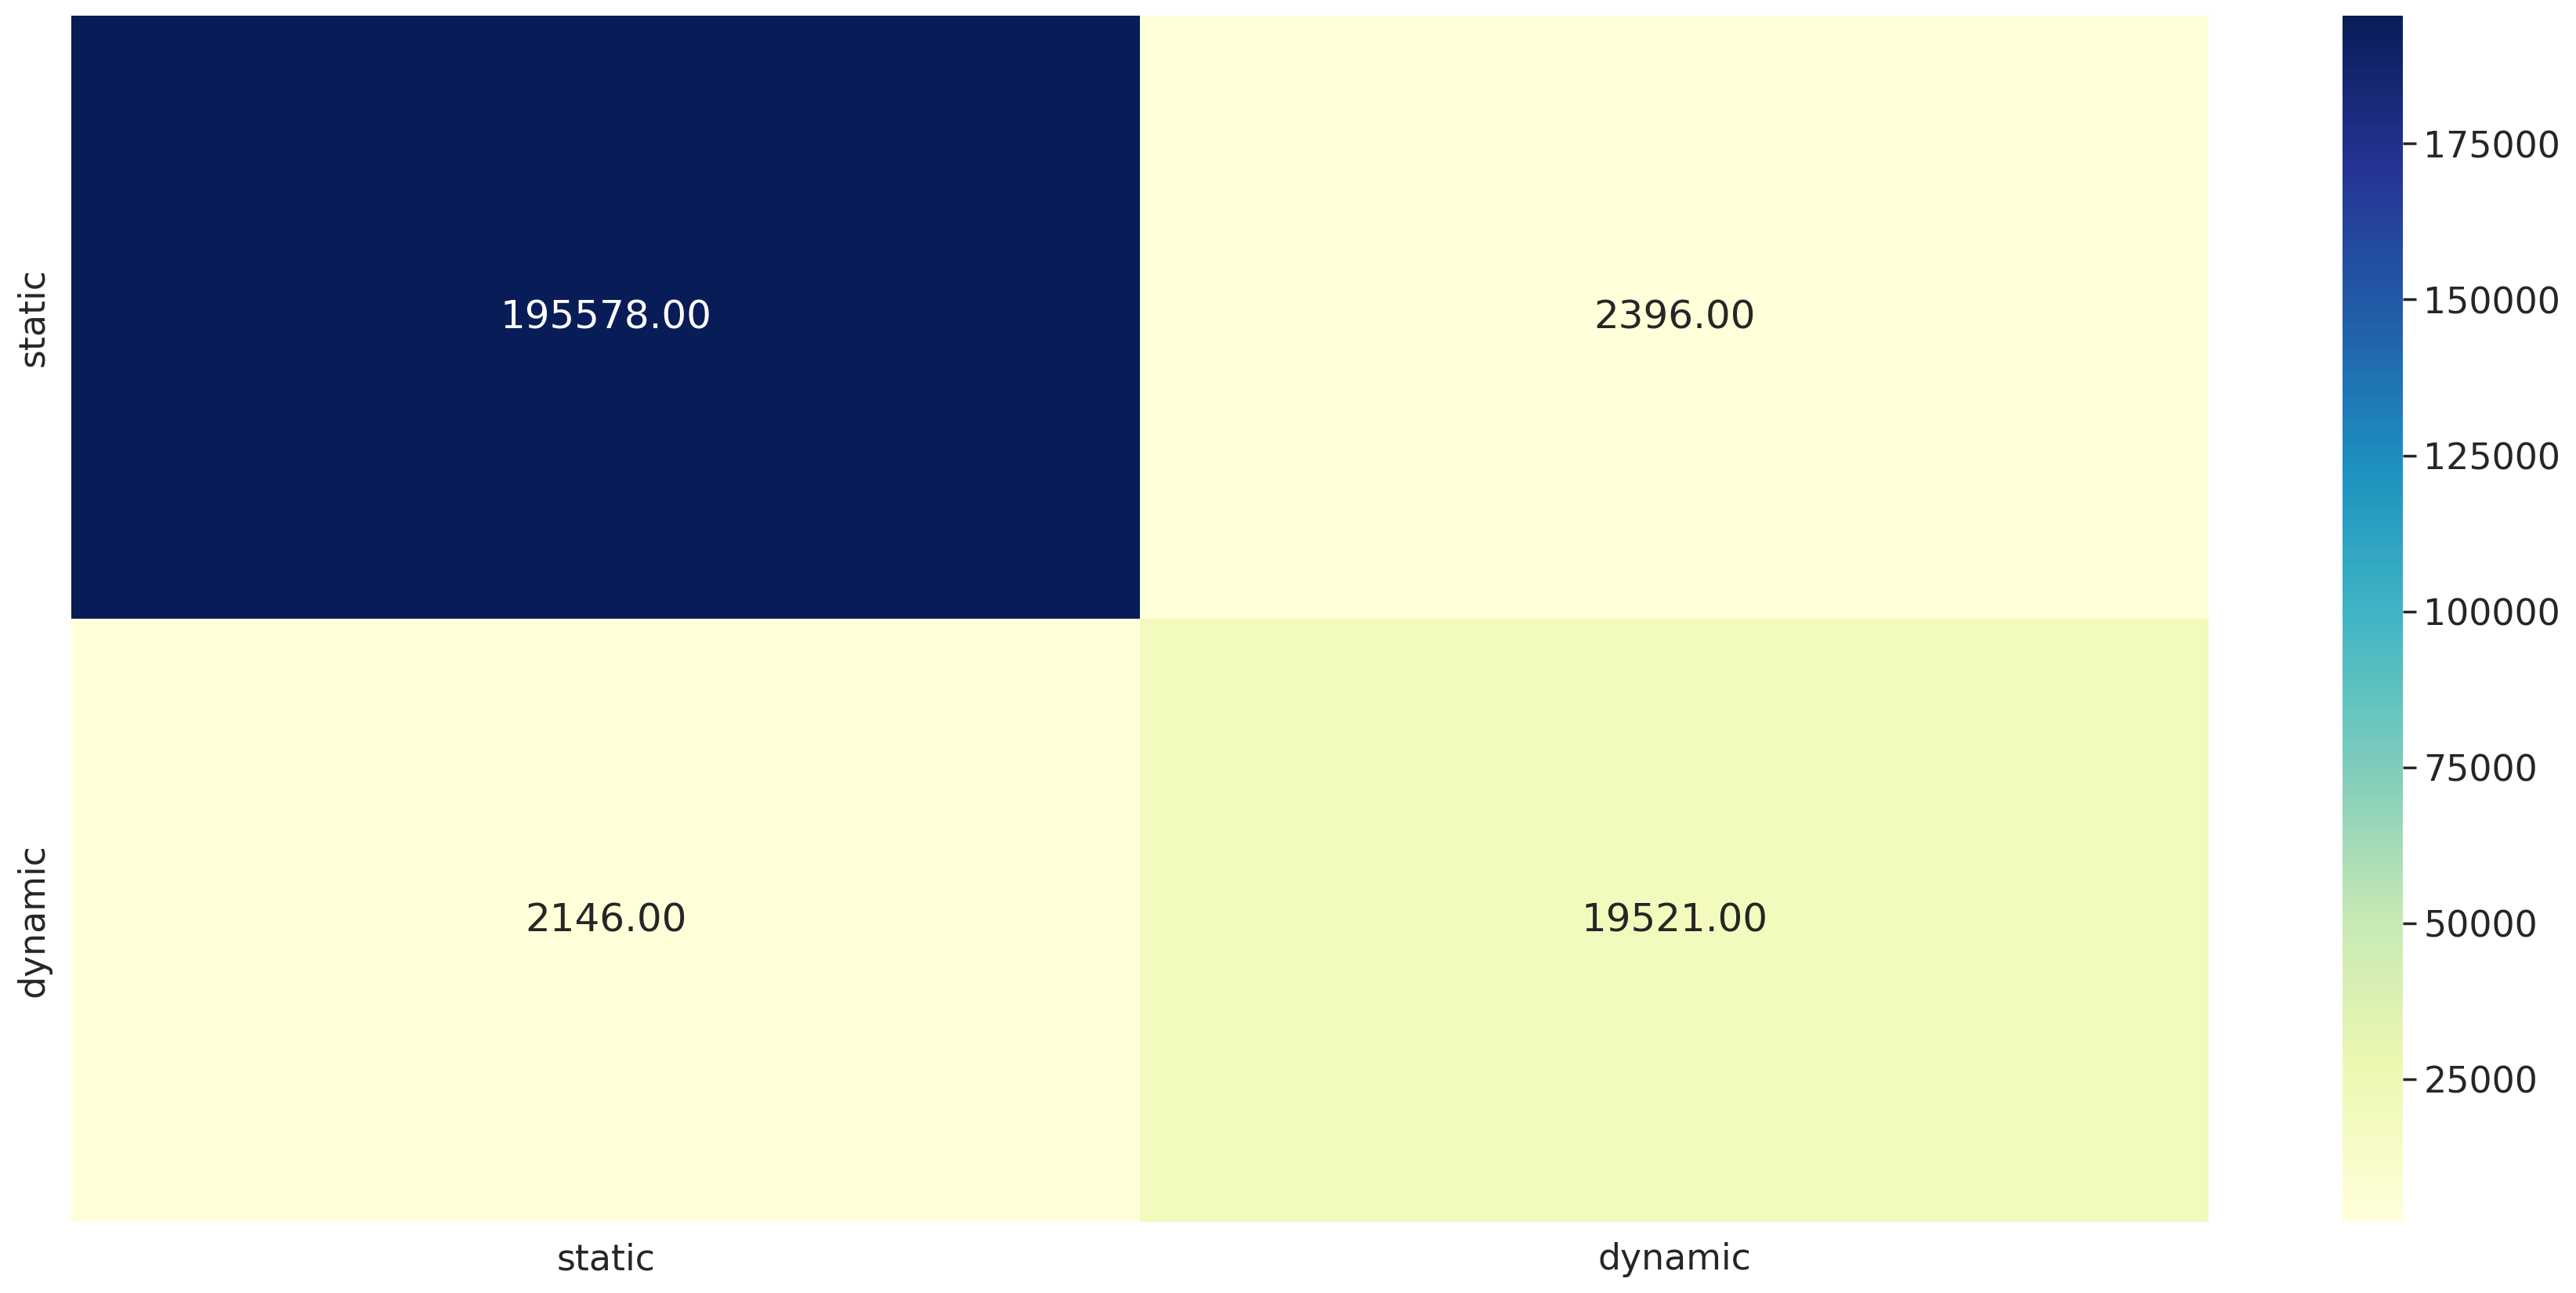

In [ ]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

pred_dt = clf_dt.predict(X_test)

print("\n--- DT Classifier ---")

y_pred= pred_dt
LABELS = ['static', 'dynamic']

cm=confusion_matrix(y_test,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

